
In this notebook supervised learning techniques are used to classify spectra for stars. Spectra are very detailed colors. Instead of 3 colors like in RGB they can have much more. In our case they are 3072 in the raw data. Like images they have numeric values. Here they are floats, thus the features are a vector 3072 floats. The spectra are normalized by fitting a linear function to a range which is does not have strong features. 

In [1]:
#basic libraries
import numpy as np

import pandas as pd
import scipy as sp

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns


#We mainly use xgboost
from xgboost import XGBClassifier
import xgboost as xgb

#some skitlearn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

#logistic regression
from sklearn.linear_model import LogisticRegression

#Keras Neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding

#Astrop.io is needed to read the files with the astronomical features. 
from astropy.io import fits

Below we load the feature and label data.

In [2]:
#directory of the data
path='/home/tobias/ml-testing/spectra-ML/met-cal-22/'
#feature data
x=np.loadtxt(path+'feature_classification.txt')
print(f"shape of feature data is {np.shape(x)}")
print(f"There are {np.shape(x)[1]} examples with each {np.shape(x)[0]} features")
#includes besides main labels also other data
yplus=np.loadtxt(path+'label_classification.txt')
print(f"shape of label data is {np.shape(yplus)}")
#there are three labels values
print(f"number of 0 labels {np.count_nonzero(yplus[0,:]==0)}")
print(f"number of 1 labels {np.count_nonzero(yplus[0,:]==1)}")
print(f"number of 2 labels {np.count_nonzero(yplus[0,:]==2)}")

shape of feature data is (3072, 3773)
There are 3773 examples with each 3072 features
shape of label data is (5, 3773)
number of 0 labels 57
number of 1 labels 3661
number of 2 labels 55


There are three exclusive labels. 1 and 2 describe different recognisable classes. 0 is for all for which the class cannot be identified.  We now look on the features to exclude some of them. 

(3072, 1, 57)


Text(0, 0.5, 'feature value')

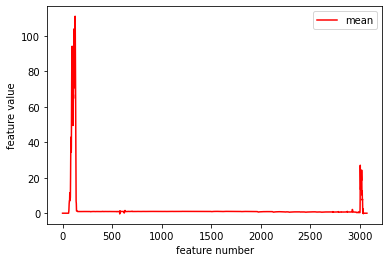

In [3]:
#separate class for statistic
class0=x[:,np.where(yplus[0,:]==0)]
class1=x[:,np.where(yplus[0,:]==1)]
class2=x[:,np.where(yplus[0,:]==2)]
print(np.shape(class0))
res=np.zeros((15,3072))
cg=np.shape(x)[1]
for i in range(3072):
    res[0,i]=i
    res[1,i]= np.count_nonzero(x[i]==0)/cg
    res[2,i]=1.92499995231628+i*0.000187174489838071  #wavelength in micron the physical meaning of the labels 
    res[3,i]=np.mean(x[i]) #statistic of all
    res[4,i]=np.median(x[i])    
    res[5,i]=np.std(x[i])  
    res[6,i]=np.mean(class0[i]) #statistic of class0
    res[7,i]=np.median(class0[i])    
    res[8,i]=np.std(class0[i])    
    res[9,i]=np.mean(class1[i]) #statistic of class0
    res[10,i]=np.median(class1[i])    
    res[11,i]=np.std(class1[i])
    res[12,i]=np.mean(class2[i]) #statistic of class0
    res[13,i]=np.median(class2[i])    
    res[14,i]=np.std(class2[i])     
plt.plot(res[0],res[3],'-',color='red',label='mean') 
plt.legend(loc="best")
#plt.xlim(1.95,2.48)
#plt.ylim(0.3,1.4)
plt.xlabel("feature number")
plt.ylabel("feature value")

Some of most extreme values have strong peaks partly. WE now zoom in them. 

Text(0, 0.5, 'feature value')

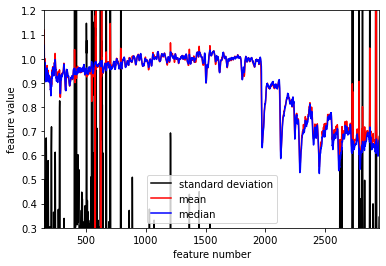

In [4]:
plt.plot(res[0],res[5],'-',color='black',label='standard deviation') 
plt.plot(res[0],res[3],'-',color='red',label='mean') 
plt.plot(res[0],res[4],'-',color='blue',label='median') 
plt.legend(loc="best")
plt.xlim(150,2950)
plt.ylim(0.3,1.2)
plt.xlabel("feature number")
plt.ylabel("feature value")

Text(0, 0.5, 'standard deviation')

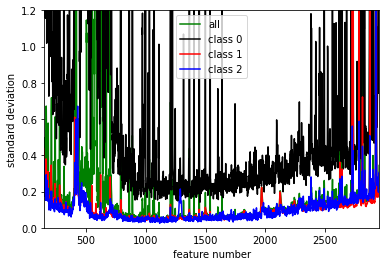

In [5]:
plt.plot(res[0],res[5],'-',color='green',label='all') 
plt.plot(res[0],res[8],'-',color='black',label='class 0') 
plt.plot(res[0],res[11],'-',color='red',label='class 1') 
plt.plot(res[0],res[14],'-',color='blue',label='class 2') 
plt.legend(loc="best")
plt.xlim(150,2950)
plt.ylim(0.0,1.2)
plt.xlabel("feature number")
plt.ylabel("standard deviation")

Text(0, 0.5, 'median')

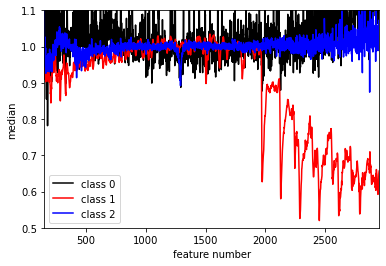

In [6]:
plt.plot(res[0],res[7],'-',color='black',label='class 0') 
plt.plot(res[0],res[10],'-',color='red',label='class 1') 
plt.plot(res[0],res[13],'-',color='blue',label='class 2') 
plt.legend(loc="best")
plt.xlim(150,2950)
plt.ylim(0.5,1.1)
plt.xlabel("feature number")
plt.ylabel("median")

For the analysis we avoid the feature ranges with string spikes. We select between 800 and 2700.

In [15]:
low=800
high=2700
#features
xsel=x[low:high]
#statistic
ressel=res[:,low:high] 
print(np.shape(ressel))
#add running feature number
resselb=np.zeros((16,1900))
resselb[0:15,:]=ressel
resselb[15,:]=np.arange(0,1900,1)
# some visulazation would be good best by type heatmap does not work too slow 
#sns.heatmap(xsel, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('features'),plt.xlabel('feature number'),plt.ylabel('example number');

(15, 1900)
[0.000e+00 1.000e+00 2.000e+00 ... 1.897e+03 1.898e+03 1.899e+03]


Classes in the selected range. 

Text(0, 0.5, 'average')

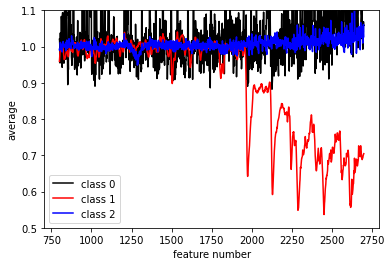

In [8]:
plt.plot(ressel[0],ressel[6],'-',color='black',label='class 0') 
plt.plot(ressel[0],ressel[9],'-',color='red',label='class 1') 
plt.plot(ressel[0],ressel[12],'-',color='blue',label='class 2') 
plt.legend(loc="best")
plt.ylim(0.5,1.1)
plt.xlabel("feature number")
plt.ylabel("average")

Text(0, 0.5, 'standard devaition')

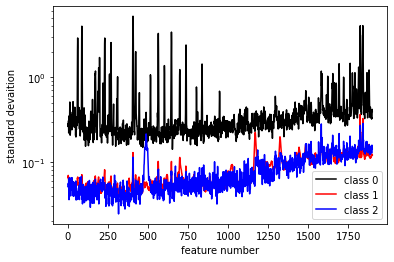

In [22]:
plt.plot(resselb[15],resselb[8],'-',color='black',label='class 0') 
plt.plot(resselb[15],resselb[11],'-',color='red',label='class 1') 
plt.plot(resselb[15],resselb[14],'-',color='blue',label='class 2') 
plt.legend(loc="best")
#plt.ylim(0,1.1)
plt.yscale("log")
plt.xlabel("feature number")
plt.ylabel("standard deviation")

There are no very narrow positive spikes visible in class 1 and 2. Class 0 has some as expected, since it consists of not so good data.

A relative large test set is used because not many sources are in the rare classes.

In [24]:
xsel_train, xsel_test, y_train, y_test, yplus_train,yplus_test= train_test_split(np.transpose(xsel), yplus[0], yplus.T, test_size=0.3, random_state=42)
print(f"shape of training features {np.shape(xsel_train)}")
print(f"shape of training labels {np.shape(y_train)}")

shape of training features (2641, 1900)
shape of training labels (2641,)


We start with logistic regression.

In [25]:
lr1 = LogisticRegression('none',max_iter=200)
lr1.fit(xsel_train,y_train)

LogisticRegression(max_iter=200, penalty='none')

In [26]:
restr=lr1.predict_proba(xsel_train)  #probabilities
reste=lr1.predict_proba(xsel_test)
restrc=lr1.predict(xsel_train)  #classes
restec=lr1.predict(xsel_test)


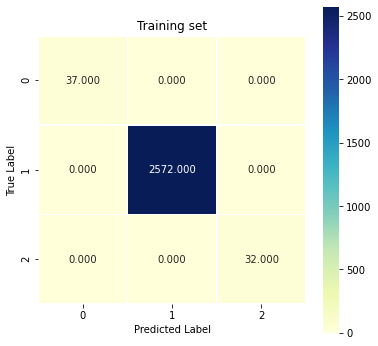

In [27]:
cm_nbtrain = confusion_matrix(y_train, restrc)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrain, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

As visisble in the confusion matrix, the model predicts the labels perfectly for the training label. In contrast 
in the test case there are a number of miss classified sources. Thus there is overfitting. 

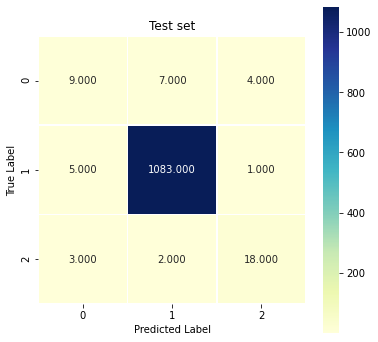

In [28]:
cm_nbtest = confusion_matrix(y_test, restec)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

To be quantitaive in decding how good the model is we use the F1 measure of each class. We use class separatly because
as expected the rare classes seem more difficult. 

In [29]:
#gets f1 score for a specified  from confusing matrix 
def fmeas(conf_matrix,x):
    if np.sum(conf_matrix[:,x])==0:
        prec=0
    else:
        prec=conf_matrix[x,x]/np.sum(conf_matrix[:,x])
    if np.sum(conf_matrix[x])==0:
        rec=0
    else:
        rec=conf_matrix[x,x]/np.sum(conf_matrix[x])

    if prec==0 and rec==0:
        f1=0
    else:
        prec=conf_matrix[x,x]/np.sum(conf_matrix[:,x])
        rec=conf_matrix[x,x]/np.sum(conf_matrix[x])
        f1=(2*prec*rec)/(prec+rec)
    return f1

In [30]:
print(f"F1 score (test, class 0) {round(fmeas(cm_nbtest,0),3)}")
print(f"F1 score (test, class 1) {round(fmeas(cm_nbtest,1),3)}")
print(f"F1 score (test, class 2) {round(fmeas(cm_nbtest,2),3)}")

F1 score (test, class 0) 0.486
F1 score (test, class 1) 0.993
F1 score (test, class 2) 0.783


The F1 is worth for class 2 and even worse for class 0. That class 0 is most difficult is to be expected, because it is a left over class.

To reduce overfitting, we now add regularization. We explore a range of regularzations parameters.


In [31]:
#regularzaition in steps of factor 2
regs=np.zeros((7,16))
regs[0,0]=10
regs[0,1]=5
regs[0,2]=2.2
regs[0,3]=1
regs[0,4]=0.5
regs[0,5]=0.22
regs[0,6]=0.1
regs[0,7]=0.05
regs[0,8]=0.022
regs[0,9]=0.01
regs[0,10]=0.005
regs[0,11]=0.0022
regs[0,12]=0.001
regs[0,13]=0.0005
regs[0,14]=0.00022
regs[0,15]=0.0001
for i in range(np.shape(regs)[1]):
    print(f"regulurization {regs[0,i]}")
    lr3 = LogisticRegression('l2',max_iter=1500,C=regs[0,i])
    lr3.fit(xsel_train,y_train)
    restrc3=lr3.predict(xsel_train)  
    restec3=lr3.predict(xsel_test)
    cm_nbtest3 = confusion_matrix(y_test, restec3)
    cm_nbtrain3 = confusion_matrix(y_train, restrc3)  
    regs[1,i]=fmeas(cm_nbtest3,0)
    regs[2,i]=fmeas(cm_nbtest3,2)
    regs[3,i]=np.mean(regs[1:3,i])
    regs[4,i]=fmeas(cm_nbtrain3,0)
    regs[5,i]=fmeas(cm_nbtrain3,2)
    regs[6,i]=np.mean(regs[4:6,i])  

regulurization 10.0
regulurization 5.0
regulurization 2.2
regulurization 1.0
regulurization 0.5
regulurization 0.22
regulurization 0.1
regulurization 0.05
regulurization 0.022
regulurization 0.01
regulurization 0.005
regulurization 0.0022
regulurization 0.001
regulurization 0.0005
regulurization 0.00022
regulurization 0.0001


F1 score (test, class 0) no regulurization 0.486
F1 score (test, class 2) no regulurization 0.783
F1 score (test, class 0) best regulurization 0.519
F1 score (test, class 2) best regulurization 0.836


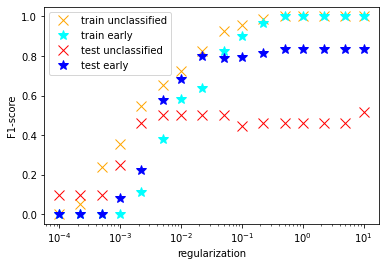

In [32]:
plt.plot(regs[0],regs[4],'x',color='orange',ms=10,label='train unclassified') 
plt.plot(regs[0],regs[5],'*',color='cyan',ms=10,label='train early') 
plt.plot(regs[0],regs[1],'x',color='red',ms=10,label='test unclassified') 
plt.plot(regs[0],regs[2],'*',color='blue',ms=10,label='test early') 
plt.legend(loc="best")
plt.xlabel("regularization")
plt.xscale("log")
plt.ylabel("F1-score")
print(f"F1 score (test, class 0) no regulurization {round(fmeas(cm_nbtest,0),3)}")
print(f"F1 score (test, class 2) no regulurization {round(fmeas(cm_nbtest,2),3)}")
print(f"F1 score (test, class 0) best regulurization {round(max(regs[1]),3)}")
print(f"F1 score (test, class 2) best regulurization {round(max(regs[2]),3)}")

Regularization improves only a little for test, the best F1 score a very similar to the F1 score with no regularization. 

Intrinsic noisy (random variation, best visible between neighboring features) clearly affects the data. It is a main reason for unclassified classifications. Logistic regression cannot recogize that from the features because of the random effects of noise and the independence of features in logistic regression. The measure of the instrinsic noisyness is the signal to onise. The signal to noise is calculated standard deviation between the features and the features smoothed with a Gaussian of a width of 1 pixel over the wavelength range between 2.08 and 2.29 were the features are normalized.
We use its inverse, the noise level here, to make it more important when the signal is low.
This feature is scaled on the a similar level as the other features, by scaling the mean in the training samples to one. 

In [33]:
#the noise lvel is feature is currently in the general labels at 7
print(f"s/n is {yplus[4]}")
#add noise to new feature vector
print(f"current feature shape of traing set is {np.shape(xsel_train)}")
#create new features
xsel_train2=np.zeros((np.shape(xsel_train)[0],np.shape(xsel_train)[1]+1))
xsel_test2=np.zeros((np.shape(xsel_test)[0],np.shape(xsel_test)[1]+1))
#copy old 
xsel_train2[:,0:np.shape(xsel_train)[1]]=xsel_train
xsel_test2[:,0:np.shape(xsel_test)[1]]=xsel_test
#add noise level as feature it
xsel_train2[:,np.shape(xsel_train)[1]]=1/yplus_train[:,4]/np.mean(1/yplus_train[:,4])
xsel_test2[:,np.shape(xsel_test)[1]]=1/yplus_test[:,4]/np.mean(1/yplus_train[:,4])
print(f"mean of noise feature is {np.mean(xsel_train2[:,np.shape(xsel_train)[1]])}")

s/n is [ 54.56041175  58.37582071  49.42498075 ...  51.15859649  93.74415085
 146.37331923]
current feature shape of traing set is (2641, 1900)
mean of noise feature is 1.0


We repeat now the regularized logistic regression but now with the noise level as additional feature.

In [34]:
#regularzaition in steps of factor 2
regs2=np.zeros((7,16))
regs2[0,0]=10
regs2[0,1]=5
regs2[0,2]=2.2
regs2[0,3]=1
regs2[0,4]=0.5
regs2[0,5]=0.22
regs2[0,6]=0.1
regs2[0,7]=0.05
regs2[0,8]=0.022
regs2[0,9]=0.01
regs2[0,10]=0.005
regs2[0,11]=0.0022
regs2[0,12]=0.001
regs2[0,13]=0.0005
regs2[0,14]=0.00022
regs2[0,15]=0.0001
for i in range(np.shape(regs2)[1]):
    print(f"regulurization {regs2[0,i]}")
    lr3 = LogisticRegression('l2',max_iter=1500,C=regs2[0,i])
    lr3.fit(xsel_train2,y_train)
    restrc3=lr3.predict(xsel_train2)  
    restec3=lr3.predict(xsel_test2)
    cm_nbtest3 = confusion_matrix(y_test, restec3)
    cm_nbtrain3 = confusion_matrix(y_train, restrc3)  
    regs2[1,i]=fmeas(cm_nbtest3,0)
    regs2[2,i]=fmeas(cm_nbtest3,2)
    regs2[3,i]=np.mean(regs2[1:3,i])
    regs2[4,i]=fmeas(cm_nbtrain3,0)
    regs2[5,i]=fmeas(cm_nbtrain3,2)
    regs2[6,i]=np.mean(regs2[4:6,i])  

regulurization 10.0
regulurization 5.0
regulurization 2.2
regulurization 1.0
regulurization 0.5
regulurization 0.22
regulurization 0.1
regulurization 0.05
regulurization 0.022
regulurization 0.01
regulurization 0.005
regulurization 0.0022
regulurization 0.001
regulurization 0.0005
regulurization 0.00022
regulurization 0.0001


F1 score (test, class 0) no regulurization 0.486
F1 score (test, class 2) no regulurization 0.783
F1 score (test, class 0) best regulurization 0.519
F1 score (test, class 2) best regulurization 0.836
F1 score (test, class 0) best regulurization with noise 0.788
F1 score (test, class 2) best regulurization with noise 0.92


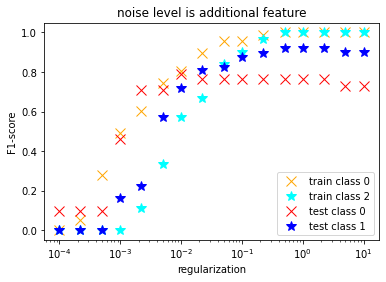

In [35]:
plt.plot(regs2[0],regs2[4],'x',color='orange',ms=10,label='train class 0') 
plt.plot(regs2[0],regs2[5],'*',color='cyan',ms=10,label='train class 2') 
plt.plot(regs2[0],regs2[1],'x',color='red',ms=10,label='test class 0') 
plt.plot(regs2[0],regs2[2],'*',color='blue',ms=10,label='test class 1') 
plt.legend(loc="best")
plt.xlabel("regularization")
plt.xscale("log")
plt.ylabel("F1-score")
plt.title("noise level is additional feature")
print(f"F1 score (test, class 0) no regulurization {round(fmeas(cm_nbtest,0),3)}")
print(f"F1 score (test, class 2) no regulurization {round(fmeas(cm_nbtest,2),3)}")
print(f"F1 score (test, class 0) best regulurization {round(max(regs[1]),3)}")
print(f"F1 score (test, class 2) best regulurization {round(max(regs[2]),3)}")
print(f"F1 score (test, class 0) best regulurization with noise {round(max(regs2[1]),3)}")
print(f"F1 score (test, class 2) best regulurization with noise {round(max(regs2[2]),3)}")

Adding the noise as additional parameter has clearly improved the classification performance. As before there is overfitting with large C since it performs better on the traing set than on the test set but the overfitting does not seem to impact the performance on the test sample much. The clasification of class 0 peaks for  C~0.01 while the earky clasfication improves until about 1 by a larger amount. That behaviour is to be expected, because in the absent of many common properties of class 0 less are needed to recognise it as well as possible in the rather small sample. 

We now look closer on the problems in classification. For that we run it again with  C of 1 and plot the confusion matrix.

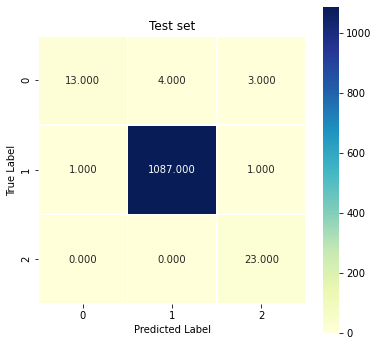

In [36]:
lr3 = LogisticRegression('l2',max_iter=1500,C=1)
lr3.fit(xsel_train2,y_train)
restrc3=lr3.predict(xsel_train2)  
restec3=lr3.predict(xsel_test2)
restrp3=lr3.predict_proba(xsel_train2)  
restep3=lr3.predict_proba(xsel_test2)
cm_nbtest4 = confusion_matrix(y_test, restec3)
cm_nbtrain4 = confusion_matrix(y_train, restrc3)  
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest4, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

As visible in the confusion matrix the main problem is that class 0 cases are classfied as other classes. We now look on the missclasfied examples. 

(1, 4, 1900)


Text(0, 0.5, 'average')

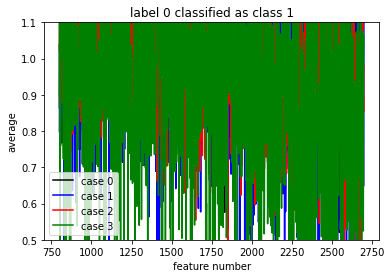

In [37]:
class0as1=xsel_test[np.where((y_test==0) & (restec3==1)),:]
class0as2=xsel_test[np.where((y_test==0) & (restec3==2)),:]
class1as0=xsel_test[np.where((y_test==1) & (restec3==0)),:]
class1as2=xsel_test[np.where((y_test==1) & (restec3==2)),:]
print(np.shape(class0as1))
plt.plot(ressel[0],class0as1[0,0,:],'-',color='black',label='case 0') 
plt.plot(ressel[0],class0as1[0,1,:],'-',color='blue',label='case 1') 
plt.plot(ressel[0],class0as1[0,2,:],'-',color='red',label='case 2') 
plt.plot(ressel[0],class0as1[0,3,:],'-',color='green',label='case 3') 
plt.title("label 0 classified as class 1")
plt.legend(loc="best")
plt.ylim(0.5,1.1)
plt.xlabel("feature number")
plt.ylabel("average")

The feature data is very noisy, therfore we smooth the data for better visualization.

Text(0, 0.5, 'average')

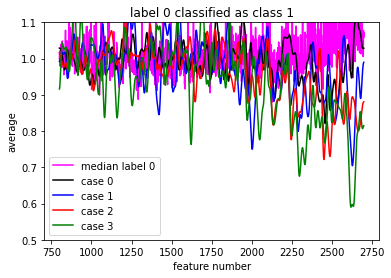

In [38]:
#add probailities in plot
plt.plot(ressel[0],ressel[7],'-',color='magenta',label='median label 0') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class0as1[0,0,:],8),'-',color='black',label='case 0') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class0as1[0,1,:],8),'-',color='blue',label='case 1') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class0as1[0,2,:],8),'-',color='red',label='case 2') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class0as1[0,3,:],8),'-',color='green',label='case 3') 
plt.legend(loc="best")
plt.ylim(0.5,1.1)
plt.title("label 0 classified as class 1")
plt.xlabel("feature number")
plt.ylabel("average")

Text(0, 0.5, 'average')

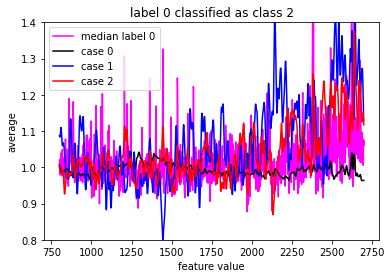

In [39]:
plt.plot(ressel[0],ressel[7],'-',color='magenta',label='median label 0') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class0as2[0,0,:],4),'-',color='black',label='case 0') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class0as2[0,1,:],4),'-',color='blue',label='case 1') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class0as2[0,2,:],4),'-',color='red',label='case 2') 
plt.legend(loc="best")
plt.ylim(0.8,1.4)
plt.title("label 0 classified as class 2")
plt.xlabel("feature value")
plt.ylabel("average")

Text(0, 0.5, 'feature value')

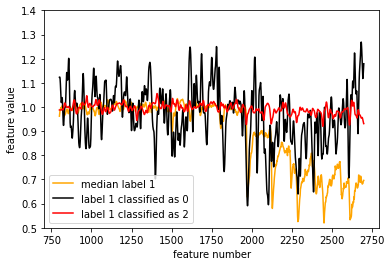

In [40]:
plt.plot(ressel[0],ressel[10],'-',color='orange',label='median label 1') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class1as0[0,0,:],4),'-',color='black',label='label 1 classified as 0') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class1as2[0,0,:],4),'-',color='red',label='label 1 classified as 2') 
plt.legend(loc="best")
plt.ylim(0.5,1.4)
plt.xlabel("feature number")
plt.ylabel("feature value")

In most cases at can be understood why sources are understood as they are. The found solution looks mostly on the integerated signal and ignore narrow spike mostly. Usally the sources is also truely clases to the found classes, like that the class 1 idefied as class 2 above, has smaller spikes 

We now look at the probabilities. 

In [41]:
for i in range(np.shape(restec3)[0]):
    if restec3[i]!=y_test[i]:
        print(f"label {round(y_test[i])} has probabilities {np.round(restep3[i],5)}")

label 0 has probabilities [0.00979 0.10217 0.88804]
label 1 has probabilities [0.01761 0.21772 0.76467]
label 0 has probabilities [0.08749 0.67432 0.23819]
label 0 has probabilities [0.15897 0.83138 0.00965]
label 1 has probabilities [0.84336 0.15463 0.00201]
label 0 has probabilities [4.5100e-03 9.9498e-01 5.1000e-04]
label 0 has probabilities [0.05502 0.00264 0.94234]
label 0 has probabilities [1.3952e-01 8.6011e-01 3.8000e-04]
label 0 has probabilities [0.20493 0.08335 0.71172]


In most cases there is still a relevant probability for the assigned label of 10% or more. Only two cases have probabilities of less than 1%.

noise coefficients are [ 0.78526054 -0.27199074 -0.5132698 ]


Text(0, 0.5, 'coefficient')

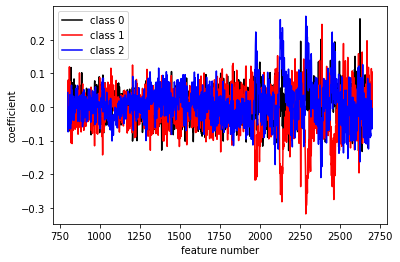

In [42]:
print(f"noise coefficients are {lr3.coef_[:,1900]}")
plt.plot(ressel[0],lr3.coef_[0,0:1900],'-',color='black',label='class 0') 
plt.plot(ressel[0],lr3.coef_[1,0:1900],'-',color='red',label='class 1') 
plt.plot(ressel[0],lr3.coef_[2,0:1900],'-',color='blue',label='class 2') 
#plt.plot(ressel[0],ressel[10],'-',color='orange',label='median label 1') 
plt.legend(loc="best")
#plt.ylim(0.5,1.4)
plt.xlabel("feature number")
plt.ylabel("coefficient")

Now smoothed for better visualization.

Text(0, 0.5, 'coefficient')

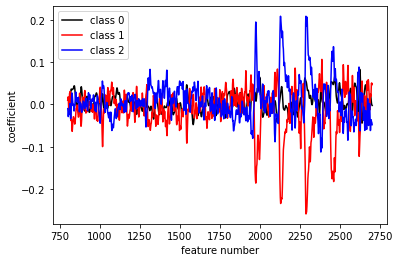

In [44]:
plt.plot(ressel[0],sp.ndimage.gaussian_filter(lr3.coef_[0,0:1900],4),'-',color='black',label='class 0') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(lr3.coef_[1,0:1900],2),'-',color='red',label='class 1') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(lr3.coef_[2,0:1900],2),'-',color='blue',label='class 2')  
plt.legend(loc="best")
#plt.ylim(0.5,1.4)
plt.xlabel("feature number")
plt.ylabel("coefficient")

The coefficents follow the strongest signal in the mean spectra of each class and of the inverse of the other classes.
In case of class 0 it is rather flat for the direct features, but the coefficient for noise is larger than anyother feature overall.  

In [45]:
#possible for ingeniering like use mean and standard deviation 100 pixel windows? 

Text(0, 0.5, 'standard deviation')

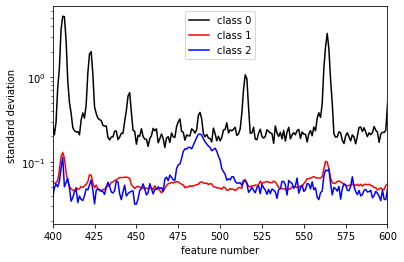

In [85]:
plt.plot(resselb[15],resselb[8],'-',color='black',label='class 0') 
plt.plot(resselb[15],resselb[11],'-',color='red',label='class 1') 
plt.plot(resselb[15],resselb[14],'-',color='blue',label='class 2') 
plt.legend(loc="best")
plt.xlim(400,600)
plt.yscale("log")
plt.xlabel("feature number")
plt.ylabel("standard deviation")

Text(0, 0.5, 'median')

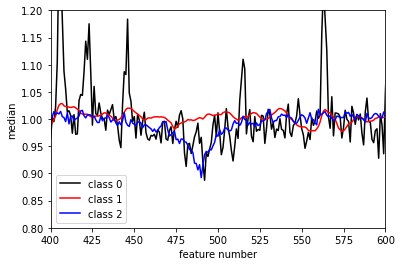

In [89]:
plt.plot(resselb[15],resselb[7],'-',color='black',label='class 0') 
plt.plot(resselb[15],resselb[10],'-',color='red',label='class 1') 
plt.plot(resselb[15],resselb[13],'-',color='blue',label='class 2') 
plt.legend(loc="best")
plt.xlim(400,600)
plt.ylim(0.8,1.2)
#plt.yscale("log")
plt.xlabel("feature number")
plt.ylabel("median")

Use local mean and standard deviation as new features. 

In [61]:
print(np.shape(xsel_train))
#in bins of 100 pixels
xbin_train=np.zeros((np.shape(xsel_train)[0],38))
xbin_test=np.zeros((np.shape(xsel_test)[0],38))
for i in range(np.shape(xsel_train)[0]):
    for j in range(19):
        xbin_train[i,j]=np.mean(xsel_train[i,j*100:100+100*j]) #mean
        xbin_train[i,j+19]=np.std(xsel_train[i,j*100:100+100*j]) #standard deviation      
for i in range(np.shape(xsel_test)[0]):
    for j in range(19):
        xbin_test[i,j]=np.mean(xsel_test[i,j*100:100+100*j]) #mean
        xbin_test[i,j+19]=np.std(xsel_test[i,j*100:100+100*j]) #standard deviation         

(2641, 1900)


In [62]:
lr4 = LogisticRegression('none',max_iter=400)
lr4.fit(xbin_train,y_train)

LogisticRegression(max_iter=400, penalty='none')

In [63]:
restr4=lr4.predict_proba(xbin_train)  #probabilities
reste4=lr4.predict_proba(xbin_test)
restrc4=lr4.predict(xbin_train)  #classes
restec4=lr4.predict(xbin_test)


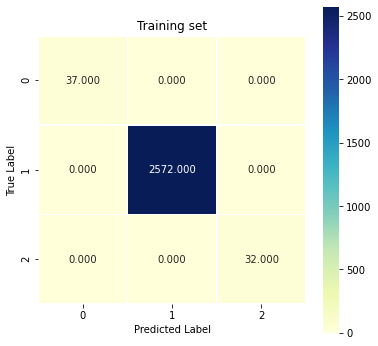

In [64]:
cm_nbtrain4 = confusion_matrix(y_train, restrc4)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrain4, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

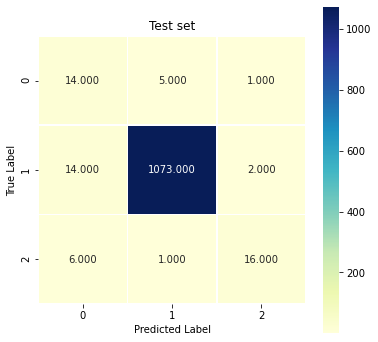

In [65]:
cm_nbtest4 = confusion_matrix(y_test, restec4)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest4, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

Is clearly less good than the previous prediction. Since train is perfect there is clear overfitting happening. 

(1, 4, 1900)
(1, 6, 38)


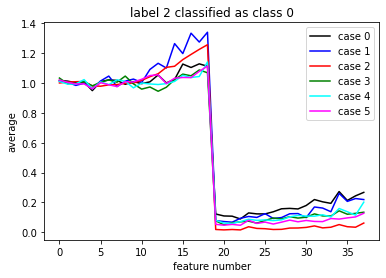

In [79]:
class0as1b=xbin_test[np.where((y_test==0) & (restec4==1)),:]
class0as2b=xbin_test[np.where((y_test==0) & (restec4==2)),:]
class2as0b=xbin_test[np.where((y_test==2) & (restec4==0)),:]
class2as1b=xbin_test[np.where((y_test==2) & (restec4==1)),:]
class1as0b=xbin_test[np.where((y_test==1) & (restec4==0)),:]
class1as2b=xbin_test[np.where((y_test==1) & (restec4==2)),:]
print(np.shape(class0as1))
plt.plot(resselb[15,0:38],class2as0b[0,0,:],'-',color='black',label='case 0') 
plt.plot(resselb[15,0:38],class2as0b[0,1,:],'-',color='blue',label='case 1') 
plt.plot(resselb[15,0:38],class2as0b[0,2,:],'-',color='red',label='case 2') 
plt.plot(resselb[15,0:38],class2as0b[0,3,:],'-',color='green',label='case 3') 
plt.plot(resselb[15,0:38],class2as0b[0,4,:],'-',color='cyan',label='case 4') 
plt.plot(resselb[15,0:38],class2as0b[0,5,:],'-',color='magenta',label='case 5') 
plt.title("label 2 classified as class 0")
plt.legend(loc="best")
#plt.ylim(0.5,1.1)
plt.xlabel("feature number")
plt.ylabel("average")
print(np.shape(class2as0b))
#curvature in the red? 

In [ ]:
#seems nit work adding std between 460 and 520 as additional feature

In [94]:
xsel_train3=np.zeros((np.shape(xsel_train2)[0],np.shape(xsel_train2)[1]+1))
xsel_test3=np.zeros((np.shape(xsel_test2)[0],np.shape(xsel_test2)[1]+1))
#copy old 
xsel_train3[:,0:np.shape(xsel_train2)[1]]=xsel_train2
xsel_test3[:,0:np.shape(xsel_test2)[1]]=xsel_test2
#add noise level as feature it
for i in range(np.shape(xsel_train)[0]):
    xsel_train3[i,np.shape(xsel_train2)[1]]=np.std(xsel_train3[i,460:520])
for i in range(np.shape(xsel_test)[0]):
    xsel_test3[i,np.shape(xsel_test2)[1]]=np.std(xsel_test3[i,460:520])
    
print(f"mean of noise feature is {np.mean(xsel_train3[:,np.shape(xsel_train2)[1]])}")
#apply that
xsel_test3[:,np.shape(xsel_test2)[1]]/=np.mean(xsel_train3[:,np.shape(xsel_train2)[1]])
xsel_train3[:,np.shape(xsel_train2)[1]]/=np.mean(xsel_train3[:,np.shape(xsel_train2)[1]])
print(f"mean of noise feature is {np.mean(xsel_train3[:,np.shape(xsel_train2)[1]])}")

mean of noise feature is 0.04313695623306053
mean of noise feature is 1.0


In [95]:
#regularzaition in steps of factor 2
regs3=np.zeros((7,16))
regs3[0,0]=10
regs3[0,1]=5
regs3[0,2]=2.2
regs3[0,3]=1
regs3[0,4]=0.5
regs3[0,5]=0.22
regs3[0,6]=0.1
regs3[0,7]=0.05
regs3[0,8]=0.022
regs3[0,9]=0.01
regs3[0,10]=0.005
regs3[0,11]=0.0022
regs3[0,12]=0.001
regs3[0,13]=0.0005
regs3[0,14]=0.00022
regs3[0,15]=0.0001
for i in range(np.shape(regs2)[1]):
    print(f"regulurization {regs2[0,i]}")
    lr3 = LogisticRegression('l2',max_iter=1500,C=regs2[0,i])
    lr3.fit(xsel_train3,y_train)
    restrc3=lr3.predict(xsel_train3)  
    restec3=lr3.predict(xsel_test3)
    cm_nbtest3 = confusion_matrix(y_test, restec3)
    cm_nbtrain3 = confusion_matrix(y_train, restrc3)  
    regs3[1,i]=fmeas(cm_nbtest3,0)
    regs3[2,i]=fmeas(cm_nbtest3,2)
    regs3[3,i]=np.mean(regs2[1:3,i])
    regs3[4,i]=fmeas(cm_nbtrain3,0)
    regs3[5,i]=fmeas(cm_nbtrain3,2)
    regs3[6,i]=np.mean(regs2[4:6,i]) 

regulurization 10.0
regulurization 5.0
regulurization 2.2
regulurization 1.0
regulurization 0.5
regulurization 0.22
regulurization 0.1
regulurization 0.05
regulurization 0.022
regulurization 0.01
regulurization 0.005
regulurization 0.0022
regulurization 0.001
regulurization 0.0005
regulurization 0.00022
regulurization 0.0001


F1 score (test, class 0) no regularization 0.486
F1 score (test, class 2) no regularization 0.783
F1 score (test, class 0) best regularization 0.519
F1 score (test, class 2) best regularization 0.836
F1 score (test, class 0) best regularization with noise 0.788
F1 score (test, class 2) best regularization with noise 0.92
F1 score (test, class 0) best regularization with noise & feature 0.765
F1 score (test, class 2) best regularization with noise & feature 0.92


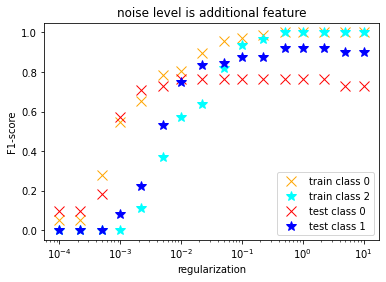

In [97]:
plt.plot(regs3[0],regs3[4],'x',color='orange',ms=10,label='train class 0') 
plt.plot(regs3[0],regs3[5],'*',color='cyan',ms=10,label='train class 2') 
plt.plot(regs3[0],regs3[1],'x',color='red',ms=10,label='test class 0') 
plt.plot(regs3[0],regs3[2],'*',color='blue',ms=10,label='test class 1') 
plt.legend(loc="best")
plt.xlabel("regularization")
plt.xscale("log")
plt.ylabel("F1-score")
plt.title("noise level is additional feature")
print(f"F1 score (test, class 0) no regularization {round(fmeas(cm_nbtest,0),3)}")
print(f"F1 score (test, class 2) no regularization {round(fmeas(cm_nbtest,2),3)}")
print(f"F1 score (test, class 0) best regularization {round(max(regs[1]),3)}")
print(f"F1 score (test, class 2) best regularization {round(max(regs[2]),3)}")
print(f"F1 score (test, class 0) best regularization with noise {round(max(regs2[1]),3)}")
print(f"F1 score (test, class 2) best regularization with noise {round(max(regs2[2]),3)}")
print(f"F1 score (test, class 0) best regularization with noise & feature {round(max(regs3[1]),3)}")
print(f"F1 score (test, class 2) best regularization with noise & feature {round(max(regs3[2]),3)}")

Is not improving, nearly no changes. 

noise coefficients are [ 0.61870689  0.02481955 -0.64352644]
brackett gamma coefficients are [ 0.27662814 -0.56232527  0.28569712]


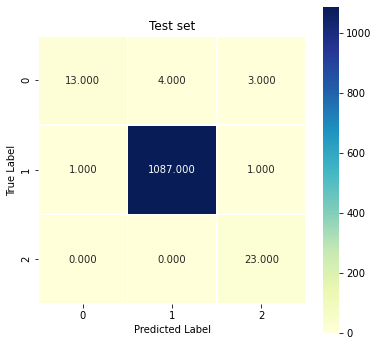

In [103]:
lr4 = LogisticRegression('l2',max_iter=1500,C=1)
lr4.fit(xsel_train3,y_train)
restrc4=lr4.predict(xsel_train3)  
restec4=lr4.predict(xsel_test3)
cm_nbtest4 = confusion_matrix(y_test, restec4)
cm_nbtrain4 = confusion_matrix(y_train, restrc4)  
print(f"noise coefficients are {lr4.coef_[:,1900]}")
print(f"brackett gamma coefficients are {lr4.coef_[:,1901]}")
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest4, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

Coefficients look right, but probably too small verall to impact in classification. 

We are now usingthe XGBoost classifier with standard settings.

In [63]:
modelx1 = XGBClassifier()
modelx1.fit(xsel_train, y_train)

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:38:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Getting the predictions of test and training.

In [64]:
y_pred_train = modelx1.predict(xsel_train)
y_pred_test = modelx1.predict(xsel_test)


We look again on the confusion matrixes.

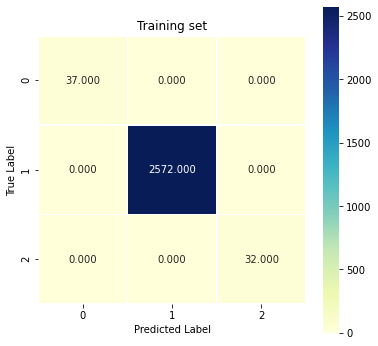

In [67]:
cm_nbtrainx1 = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrainx1, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

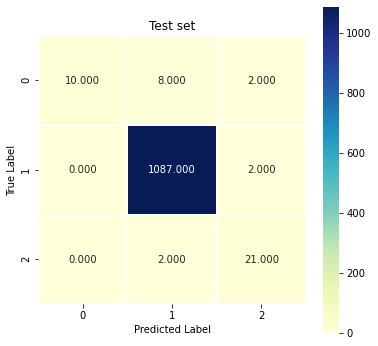

In [68]:
cm_nbtestx1 = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtestx1, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

In [84]:
print(f"precision of early in training: {cm_nbtrainx1[2,2]/np.sum(cm_nbtrainx1[:,2])}")
print(f"recall of early in training: {cm_nbtrainx1[2,2]/np.sum(cm_nbtrainx1[2])}")
print(f"precision of unclassified in training: {cm_nbtrainx1[0,0]/np.sum(cm_nbtrainx1[:,0])}")
print(f"recall of unclassified in training: {cm_nbtrainx1[0,0]/np.sum(cm_nbtrainx1[0])}")

print(f"precision of early in test: {cm_nbtestx1[2,2]/np.sum(cm_nbtestx1[:,2])}")
print(f"recall of early in test: {cm_nbtestx1[2,2]/np.sum(cm_nbtestx1[2])}")
print(f"precision of unclassified in test: {cm_nbtestx1[0,0]/np.sum(cm_nbtestx1[:,0])}")
print(f"recall of unclassified in test: {cm_nbtestx1[0,0]/np.sum(cm_nbtestx1[0])}")

print(f"F1 score (test, class 0) logistic regression {round(fmeas(cm_nbtest,0),3)}")
print(f"F1 score (test, class 2) logistic regression {round(fmeas(cm_nbtest,2),3)}")
print(f"F1 score (test, class 0) logistic regression with noise {round(fmeas(cm_nbtest4,0),3)}")
print(f"F1 score (test, class 2) logistic regression with noise {round(fmeas(cm_nbtest4,2),3)}")
print(f"F1 score (test, class 0) xgboost {round(fmeas(cm_nbtestx1,0),3)}")
print(f"F1 score (test, class 2) xgboost {round(fmeas(cm_nbtestx1,2),3)}")

precision of early in training: 1.0
recall of early in training: 1.0
precision of unclassified in training: 1.0
recall of unclassified in training: 1.0
precision of early in test: 0.84
recall of early in test: 0.9130434782608695
precision of unclassified in test: 1.0
recall of unclassified in test: 0.5
F1 score (test, class 0) logistic regression 0.486
F1 score (test, class 2) logistic regression 0.783
F1 score (test, class 0) logistic regression with noise 0.765
F1 score (test, class 2) logistic regression with noise 0.92
F1 score (test, class 0) xgboost 0.667
F1 score (test, class 2) xgboost 0.875


In training the labels are perfectly predicted. In the test also class 1 is also very good classified, only two truly late or predicted as different. In contrast, the prediction is less good for class 2 and even more for class 0. Especially, recall of unclassified is bad because the unclassified stars are wrongly classified because the class unclassfied as found by xgb is too narrow. That late is easiest is expected because late is the most abundant and most homogen class. Overall, the difference between test and tarining shows that there is overfitting. 
There is clear improvement compared to logistic regression.  

For counterimng overfitting the model needs to be changed. Given the few test samples best is a way with not too many free parameters. Therefore, I select subsample where there is only one parameter. 

In [73]:
modelx2 = XGBClassifier(subsample=0.5)
modelx2.fit(xsel_train, y_train)

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:40:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [74]:
y2_pred_train = modelx2.predict(xsel_train)
y2_pred_test = modelx2.predict(xsel_test)

There are still all right in the training set and clearly less in test set. There is some improvemnt in the test set, especially for the unclassified.

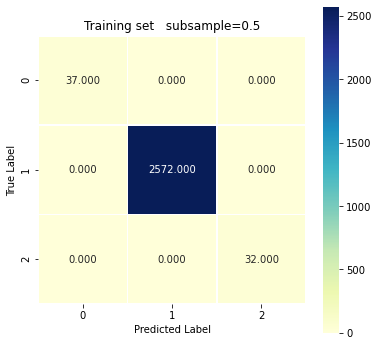

In [75]:
cm_nbtrainx2 = confusion_matrix(y_train, y2_pred_train)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrainx2, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set   subsample=0.5'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

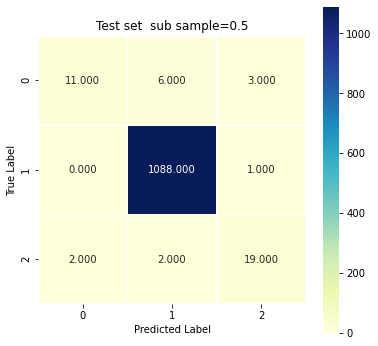

In [76]:
cm_nbtestx2 = confusion_matrix(y_test, y2_pred_test)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtestx2, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set  sub sample=0.5'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

In [85]:
print(f"precision of early in training: {cm_nbtrainx2[2,2]/np.sum(cm_nbtrainx2[:,2])}")
print(f"recall of early in training: {cm_nbtrainx2[2,2]/np.sum(cm_nbtrainx2[2])}")
print(f"precision of unclassified in training: {cm_nbtrainx2[0,0]/np.sum(cm_nbtrainx2[:,0])}")
print(f"recall of unclassified in training: {cm_nbtrainx2[0,0]/np.sum(cm_nbtrainx2[0])}")

print(f"precision of early in test: {cm_nbtestx2[2,2]/np.sum(cm_nbtestx2[:,2])}")
print(f"recall of early in test: {cm_nbtestx2[2,2]/np.sum(cm_nbtestx2[2])}")
print(f"precision of unclassified in test: {cm_nbtestx2[0,0]/np.sum(cm_nbtestx2[:,0])}")
print(f"recall of unclassified in test: {cm_nbtestx2[0,0]/np.sum(cm_nbtestx2[0])}")

print(f"F1 score (test, class 0) xgboost full sample {round(fmeas(cm_nbtestx1,0),3)}")
print(f"F1 score (test, class 2) xgboost full sample {round(fmeas(cm_nbtestx1,2),3)}")
print(f"F1 score (test, class 0) xgboost sample=0.5 {round(fmeas(cm_nbtestx2,0),3)}")
print(f"F1 score (test, class 2) xgboost sample=0.5 {round(fmeas(cm_nbtestx2,2),3)}")
print(f"F1 score (test, class 0) logistic regression with noise {round(fmeas(cm_nbtest4,0),3)}")
print(f"F1 score (test, class 2) logistic regression with noise {round(fmeas(cm_nbtest4,2),3)}")

precision of early in training: 1.0
recall of early in training: 1.0
precision of unclassified in training: 1.0
recall of unclassified in training: 1.0
precision of early in test: 0.8260869565217391
recall of early in test: 0.8260869565217391
precision of unclassified in test: 0.8461538461538461
recall of unclassified in test: 0.55
F1 score (test, class 0) xgboost full sample 0.667
F1 score (test, class 2) xgboost full sample 0.875
F1 score (test, class 0) xgboost sample=0.5 0.667
F1 score (test, class 2) xgboost sample=0.5 0.826
F1 score (test, class 0) logistic regression with noise 0.765
F1 score (test, class 2) logistic regression with noise 0.92


To explore the subsample paramter more we run more models systematically.

In [78]:
#In ress the are summariyed using the F1 score. 
#First the f1 score of the current models early and unclassufied and their average 
ress=np.zeros((7,10))
ress[0,0]=1.0
ress[1,0]=fmeas(cm_nbtrainx1,int(2))
ress[2,0]=fmeas(cm_nbtrainx1,int(0))
ress[3,0]=(ress[1,0]+ress[2,0])/2
ress[4,0]=fmeas(cm_nbtestx1,int(2))
ress[5,0]=fmeas(cm_nbtestx1,int(0))
ress[6,0]=(ress[4,0]+ress[5,0])/2
ress[0,1]=0.5
ress[1,1]=fmeas(cm_nbtrainx2,int(2))
ress[2,1]=fmeas(cm_nbtrainx2,int(0))
ress[3,1]=(ress[1,1]+ress[2,1])/2
ress[4,1]=fmeas(cm_nbtestx2,int(2))
ress[5,1]=fmeas(cm_nbtestx2,int(0))
ress[6,1]=(ress[4,1]+ress[5,1])/2
#defining the further subsample values
ress[0,2]=0.33
ress[0,3]=0.2
ress[0,4]=0.14
ress[0,5]=0.1
ress[0,6]=0.07
ress[0,7]=0.05
ress[0,8]=0.04
ress[0,9]=0.03

In [79]:
#running for more subsample values
for i in range(2,10):
    print(i)
    print(f"subsample of {ress[0,i]}")
    model3 = XGBClassifier(subsample=ress[0,i])  
    model3.fit(xsel_train,y_train)
    y3_pred_train = model3.predict(xsel_train)
    y3_pred_test = model3.predict(xsel_test)
    cm_nbtrain3 = confusion_matrix(y_train, y3_pred_train)
    cm_nbtest3 = confusion_matrix(y_test, y3_pred_test)
    ress[1,i]=fmeas(cm_nbtrain3,int(2))
    ress[2,i]=fmeas(cm_nbtrain3,int(0))
    ress[3,i]=(ress[1,i]+ress[2,i])/2
    ress[4,i]=fmeas(cm_nbtest3,int(2))
    ress[5,i]=fmeas(cm_nbtest3,int(0))
    ress[6,i]=(ress[4,i]+ress[5,i])/2

2
subsample of 0.33


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:40:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
3
subsample of 0.2


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:40:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
4
subsample of 0.14
[15:40:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


5
subsample of 0.1
[15:40:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


6
subsample of 0.07
[15:40:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


7
subsample of 0.05


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:40:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
8
subsample of 0.04
[15:40:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


9
subsample of 0.03
[15:40:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In training the score decreases continiously wuth subsample size. In the test sample the evolution of the F1-score is usually smaller overall and it is noisy with up and downs. The optimum values is different for unclassified and early. Overall the score is rather flat. Small subsample perform worse but including0.07 and bove there is no clear preferance, all achive about 0.73 to 0.82 as F1-score average over the two rare classes.

[0.77083333 0.74637681 0.81713555 0.79504505 0.78119658 0.72782705
 0.77960526 0.69886364 0.70559006 0.5042735 ]
[1.   0.5  0.33 0.2  0.14 0.1  0.07 0.05 0.04 0.03]
F1 score (test, class 0) logistic regression with noise 0.765
F1 score (test, class 2) logistic regression with noise 0.92


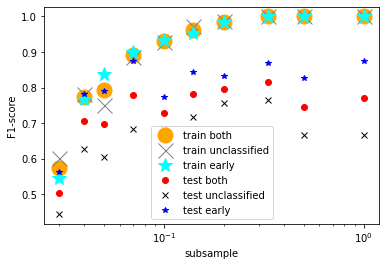

In [88]:
plt.plot(ress[0],ress[3],'o',ms=15,color='orange',label='train both') 
plt.plot(ress[0],ress[2],'x',ms=15,color='gray',label='train unclassified') 
plt.plot(ress[0],ress[1],'*',ms=15,color='cyan',label='train early') 
plt.plot(ress[0],ress[6],'o',color='red',label='test both') 
plt.plot(ress[0],ress[5],'x',color='black',label='test unclassified') 
plt.plot(ress[0],ress[4],'*',color='blue',label='test early') 
plt.legend(loc="best")
plt.xlabel("subsample")
plt.xscale("log")
plt.ylabel("F1-score")
print(ress[6])
print(ress[0])
print(f"F1 score (test, class 0) logistic regression with noise {round(fmeas(cm_nbtest4,0),3)}")
print(f"F1 score (test, class 2) logistic regression with noise {round(fmeas(cm_nbtest4,2),3)}")

Better than logistic on class 0 but worse on class 2.

Using different weights for the classes should improve performance for rare classes.

In [89]:
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)
print(np.min(classes_weights))
print(np.max(classes_weights))

0.34227579056505963
27.510416666666668


In [90]:
xgb_classifier8 = xgb.XGBClassifier(subsample=0.5)
xgb_classifier8.fit(xsel_train, y_train, sample_weight=classes_weights)

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:47:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [91]:
y8_pred_train = xgb_classifier8.predict(xsel_train)
y8_pred_test = xgb_classifier8.predict(xsel_test)

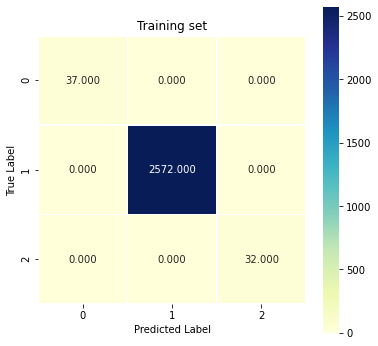

In [92]:
cm_nbtrain8 = confusion_matrix(y_train, y8_pred_train)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrain8, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

[[-1  1  0]
 [ 3 -4  1]
 [-2 -2  4]]
F1 score with w/o weights class 0: 0.667
F1 score with w/o weights class 2: 0.826
F1 score with weights class 0: 0.606
F1 score with weights class 2: 0.902
F1 score (test, class 0) logistic regression with noise 0.765
F1 score (test, class 2) logistic regression with noise 0.92


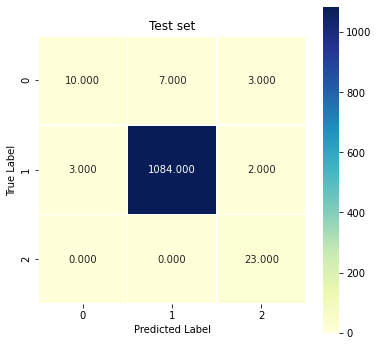

In [94]:
cm_nbtest8 = confusion_matrix(y_test, y8_pred_test)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest8, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');
print(cm_nbtest8-cm_nbtestx2)  
print(f"F1 score with w/o weights class 0: {round(fmeas(cm_nbtestx2,0),3)}")
print(f"F1 score with w/o weights class 2: {round(fmeas(cm_nbtestx2,2),3)}")
print(f"F1 score with weights class 0: {round(fmeas(cm_nbtest8,0),3)}")
print(f"F1 score with weights class 2: {round(fmeas(cm_nbtest8,2),3)}")
print(f"F1 score (test, class 0) logistic regression with noise {round(fmeas(cm_nbtest4,0),3)}")
print(f"F1 score (test, class 2) logistic regression with noise {round(fmeas(cm_nbtest4,2),3)}")

Using weights in the fitting improves performance in the measures for the rare classes overall but not by by much because the number of corrected unclassified decreases. 

We now run weighted for all the same subsamples fraction as before. 

In [95]:
ress2=np.zeros((7,10))
ress2[0,:]=ress[0,:]
print(ress2[0,:])

[1.   0.5  0.33 0.2  0.14 0.1  0.07 0.05 0.04 0.03]


In [96]:
for i in range(10):
    print(f"sub sample of {ress2[0,i]}")
    xgb_classifier9 = xgb.XGBClassifier(subsample=ress2[0,i])
    xgb_classifier9.fit(xsel_train, y_train, sample_weight=classes_weights)
    y9_pred_train = xgb_classifier9.predict(xsel_train)
    y9_pred_test = xgb_classifier9.predict(xsel_test)
    cm_nbtrain9 = confusion_matrix(y_train, y9_pred_train)
    cm_nbtest9 = confusion_matrix(y_test, y9_pred_test)
    ress2[1,i]=fmeas(cm_nbtrain9,int(2))
    ress2[2,i]=fmeas(cm_nbtrain9,int(0))
    ress2[3,i]=(ress2[1,i]+ress2[2,i])/2
    ress2[4,i]=fmeas(cm_nbtest9,int(2))
    ress2[5,i]=fmeas(cm_nbtest9,int(0))
    ress2[6,i]=(ress2[4,i]+ress2[5,i])/2

sub sample of 1.0


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.5


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.33


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.2


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.14
[15:48:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


sub sample of 0.1
[15:48:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


sub sample of 0.07
[15:48:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


sub sample of 0.05


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.04
[15:48:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


sub sample of 0.03


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Sub sample of 0.2 performs best for unclassified and is also close to best for early. In principle it still overfits the training data but when that is not anymore the care (below subsample of 0.1), the performance on the test data is also worse.

Text(0.5, 1.0, 'weighted fits')

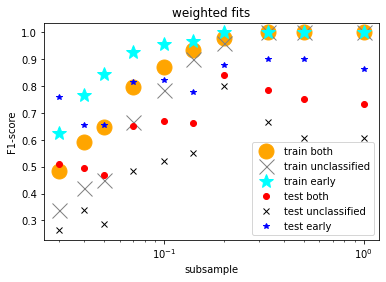

In [97]:
plt.plot(ress2[0],ress2[3],'o',ms=15,color='orange',label='train both') 
plt.plot(ress2[0],ress2[2],'x',ms=15,color='gray',label='train unclassified') 
plt.plot(ress2[0],ress2[1],'*',ms=15,color='cyan',label='train early') 
plt.plot(ress2[0],ress2[6],'o',color='red',label='test both') 
plt.plot(ress2[0],ress2[5],'x',color='black',label='test unclassified') 
plt.plot(ress2[0],ress2[4],'*',color='blue',label='test early') 
plt.legend(loc="best")
plt.xlabel("subsample")
plt.xscale("log")
plt.ylabel("F1-score")
plt.title("weighted fits")

F1 score (test, class 0) logistic regression with noise 0.765
F1 score (test, class 2) logistic regression with noise 0.92


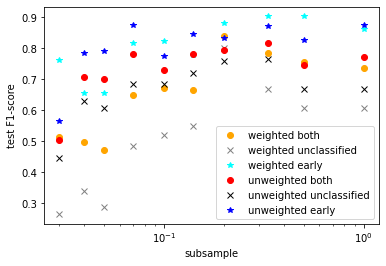

In [99]:
plt.plot(ress2[0],ress2[6],'o',color='orange',label='weighted both') 
plt.plot(ress2[0],ress2[5],'x',color='gray',label='weighted unclassified') 
plt.plot(ress2[0],ress2[4],'*',color='cyan',label='weighted early') 
plt.plot(ress[0],ress[6],'o',color='red',label='unweighted both') 
plt.plot(ress[0],ress[5],'x',color='black',label='unweighted unclassified') 
plt.plot(ress[0],ress[4],'*',color='blue',label='unweighted early') 
plt.legend(loc="best")
plt.xlabel("subsample")
plt.xscale("log")
plt.ylabel("test F1-score")
print(f"F1 score (test, class 0) logistic regression with noise {round(fmeas(cm_nbtest4,0),3)}")
print(f"F1 score (test, class 2) logistic regression with noise {round(fmeas(cm_nbtest4,2),3)}")


Now we add the instrinsic noise as additional feature. 

Fit with subsample of 0.5 as before. 

In [102]:
model10 = XGBClassifier(subsample=0.5)
model10.fit(xsel_train2, y_train)

[15:53:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [103]:
y10_pred_train = model10.predict(xsel_train2)
y10_pred_test = model10.predict(xsel_test2)

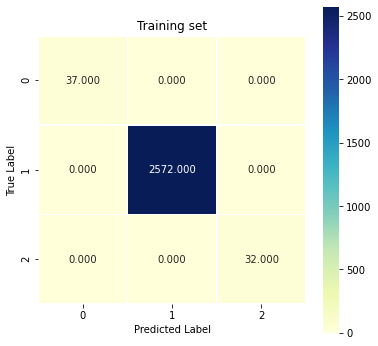

In [104]:
cm_nbtrain10 = confusion_matrix(y_train, y10_pred_train)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrain10, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

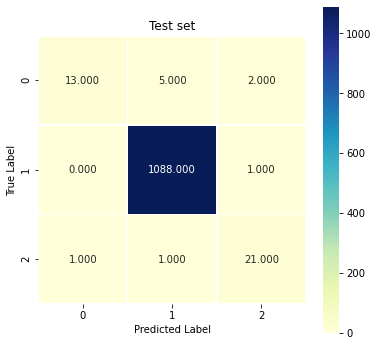

In [106]:
cm_nbtest10 = confusion_matrix(y_test, y10_pred_test)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest10, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

The F1 score of early is on the same level as the best before. The one of unclassified is somewhat worse. However, we have not added weights here and also not tried subsample, thus the comparsion is not fair. 

In [107]:
print("all is for the test set")
print(f"F1-score unclassified {fmeas(cm_nbtest10,0)}")
print(f"best F1-score of unclassified before was {max(np.max(ress[5]),np.max(ress2[5]))}")
print(f"F1-score early {fmeas(cm_nbtest10,2)}")
print(f"best F1-score of early before was {max(np.max(ress[4]),np.max(ress2[4]))}")
print(f"F1 score (test, class 0) logistic regression with noise {round(fmeas(cm_nbtest4,0),3)}")
print(f"F1 score (test, class 2) logistic regression with noise {round(fmeas(cm_nbtest4,2),3)}")

all is for the test set
F1-score unclassified 0.7647058823529412
best F1-score of unclassified before was 0.8000000000000002
F1-score early 0.8936170212765957
best F1-score of early before was 0.9019607843137255
F1 score (test, class 0) logistic regression with noise 0.765
F1 score (test, class 2) logistic regression with noise 0.92


In [ ]:
#could look on misspredictions again, but seems to be worse anyway than logistic and less understandable also 

Now also adding weights to fit. 

In [108]:
xgb_classifier11 = xgb.XGBClassifier(subsample=0.5)
xgb_classifier11.fit(xsel_train2, y_train, sample_weight=classes_weights)

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [109]:
y11_pred_train = xgb_classifier11.predict(xsel_train2)
y11_pred_test = xgb_classifier11.predict(xsel_test2)

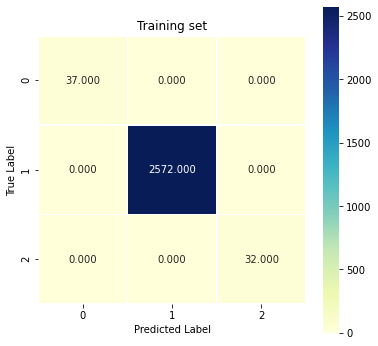

In [110]:
cm_nbtrain11 = confusion_matrix(y_train, y11_pred_train)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrain11, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

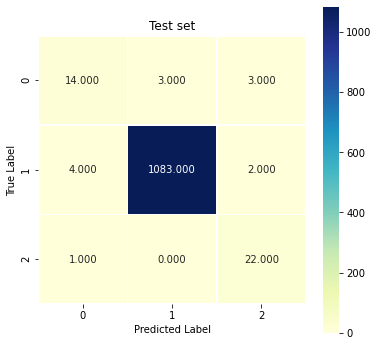

In [111]:
cm_nbtest11 = confusion_matrix(y_test, y11_pred_test)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest11, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

With the weights the classification does not improve even for the rare classes. As expected there is also worse classification of the late labelled ones.

In [113]:
print("all is for the test set")
print(f"F1-score unclassified unweighted {fmeas(cm_nbtest10,0)}")
print(f"F1-score unclassified weighted {fmeas(cm_nbtest11,0)}")
print(f"F1-score early unweighted {fmeas(cm_nbtest10,2)}")
print(f"F1-score early weighted {fmeas(cm_nbtest11,2)}")
print(f"F1 score (test, class 0) logistic regression with noise {round(fmeas(cm_nbtest4,0),3)}")
print(f"F1 score (test, class 2) logistic regression with noise {round(fmeas(cm_nbtest4,2),3)}")

all is for the test set
F1-score unclassified unweighted 0.7647058823529412
F1-score unclassified weighted 0.717948717948718
F1-score early unweighted 0.8936170212765957
F1-score early weighted 0.8800000000000001
F1 score (test, class 0) logistic regression with noise 0.765
F1 score (test, class 2) logistic regression with noise 0.92


Now we run unweighted with the additional noise label for the same sub sample values as before. 

In [114]:
ress3=np.zeros((7,10))
ress3[0,:]=ress[0,:]
for i in range(10):
    print(f"subsample of {ress3[0,i]}")
    model3 = XGBClassifier(subsample=ress3[0,i])  
    model3.fit(xsel_train2,y_train)
    y3_pred_train = model3.predict(xsel_train2)
    y3_pred_test = model3.predict(xsel_test2)
    cm_nbtrain3 = confusion_matrix(y_train, y3_pred_train)
    cm_nbtest3 = confusion_matrix(y_test, y3_pred_test)
    ress3[1,i]=fmeas(cm_nbtrain3,int(2))
    ress3[2,i]=fmeas(cm_nbtrain3,int(0))
    ress3[3,i]=(ress3[1,i]+ress3[2,i])/2
    ress3[4,i]=fmeas(cm_nbtest3,int(2))
    ress3[5,i]=fmeas(cm_nbtest3,int(0))
    ress3[6,i]=(ress3[4,i]+ress3[5,i])/2

subsample of 1.0


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
subsample of 0.5


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
subsample of 0.33


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
subsample of 0.2
[15:56:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


subsample of 0.14
[15:56:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


subsample of 0.1
[15:56:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


subsample of 0.07
[15:57:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


subsample of 0.05
[15:57:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


subsample of 0.04
[15:57:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


subsample of 0.03
[15:57:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Sub sample of 0.5 is clearly the best sub sample of all for the test set. The values for the others are rather similar besides of the lowest one for 0.03.

F1 score (test, class 0) logistic regression with noise 0.765
F1 score (test, class 2) logistic regression with noise 0.92


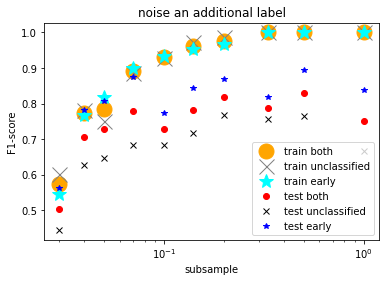

In [116]:
plt.plot(ress3[0],ress3[3],'o',ms=15,color='orange',label='train both') 
plt.plot(ress3[0],ress3[2],'x',ms=15,color='gray',label='train unclassified') 
plt.plot(ress3[0],ress3[1],'*',ms=15,color='cyan',label='train early') 
plt.plot(ress3[0],ress3[6],'o',color='red',label='test both') 
plt.plot(ress3[0],ress3[5],'x',color='black',label='test unclassified') 
plt.plot(ress3[0],ress3[4],'*',color='blue',label='test early') 
plt.legend(loc="best")
plt.xlabel("subsample")
plt.xscale("log")
plt.ylabel("F1-score")
plt.title("noise an additional label")
print(f"F1 score (test, class 0) logistic regression with noise {round(fmeas(cm_nbtest4,0),3)}")
print(f"F1 score (test, class 2) logistic regression with noise {round(fmeas(cm_nbtest4,2),3)}")

Logistic regression seems to be the best still. 

In [118]:
#other ideas as real three paramters *not much sense just would for pseudo expertise, or use lamba single parameter

In [119]:
#add neural network at least as trial 
print(np.shape(xsel_test))

(1132, 1900)


In [120]:
#small Neural network
modeln1 = Sequential(
    [              
        tf.keras.Input(shape=(1900,)),  
        Dense(5, activation="relu",  name="layer1"),  
        Dense(3, activation = 'linear', name="layer2")
    ], name = "modeln1"
) 
modeln1.summary()

Model: "modeln1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 5)                 9505      
                                                                 
 layer2 (Dense)              (None, 3)                 18        
                                                                 
Total params: 9,523
Trainable params: 9,523
Non-trainable params: 0
_________________________________________________________________


In [121]:
modeln1.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(0.001),
)

In [132]:
trainre=xsel_train[0:np.shape(xsel_train)[0]].reshape(np.shape(xsel_train)[0],np.shape(xsel_train)[1])
testre=xsel_test[0:np.shape(xsel_test)[0]].reshape(np.shape(xsel_test)[0],np.shape(xsel_test)[1])
resn1=np.zeros((5,10))
for i in range(10):
    print(i)
    modeln1.fit(
        xsel_train,y_train,
        epochs=320,batch_size=1900 #all at once because data set is not really large
    )
    resn1[0,i]=(i+1)*320
    prediction1p = modeln1.predict(trainre)
    sm_prediction1p = tf.nn.softmax(prediction1p).numpy()
    restrain=np.zeros(np.shape(prediction1p)[0])
    for j in range(np.shape(prediction1p)[0]): #most likely prediction
        restrain[j]=np.argmax(prediction1p[j])
    prediction1p_test = modeln1.predict(testre)
    sm_prediction1p_test = tf.nn.softmax(prediction1p_test).numpy()
    restest=np.zeros(np.shape(prediction1p_test)[0])
    for j in range(np.shape(prediction1p_test)[0]):
        restest[j]=np.argmax(prediction1p_test[j]) 
    cm_nbtrainn1 = confusion_matrix(y_train, restrain)
    cm_nbtestn1 = confusion_matrix(y_test, restest)
    resn1[1,i]=fmeas(cm_nbtrainn1,0) 
    resn1[2,i]=fmeas(cm_nbtrainn1,2)
    resn1[3,i]=fmeas(cm_nbtestn1,0)
    resn1[4,i]=fmeas(cm_nbtestn1,2)    

0
Epoch 1/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 2/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 3/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0037
Epoch 4/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0037
Epoch 5/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 6/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 7/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0037
Epoch 8/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 9/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0037
Epoch 10/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0037
Epoch 11/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 12/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0037
Epoch 13/320
2/2 [==============================] - 0s 6ms/

2/2 [==============================] - 0s 8ms/step - loss: 0.0036
Epoch 207/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 208/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0036
Epoch 209/320
2/2 [==============================] - 0s 14ms/step - loss: 0.0036
Epoch 210/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0036
Epoch 211/320
2/2 [==============================] - 0s 10ms/step - loss: 0.0036
Epoch 212/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0036
Epoch 213/320
2/2 [==============================] - 0s 10ms/step - loss: 0.0036
Epoch 214/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 215/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0036
Epoch 216/320
2/2 [==============================] - 0s 10ms/step - loss: 0.0036
Epoch 217/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0036
Epoch 218/320
2/2 [==============================]

2/2 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 91/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0036
Epoch 92/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 93/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 94/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 95/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 96/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 97/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 98/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 99/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0036
Epoch 100/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 101/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 102/320
2/2 [==============================] - 0s 7ms/ste

2/2 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 295/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 296/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0035
Epoch 297/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0035
Epoch 298/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 299/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 300/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 301/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 302/320
2/2 [==============================] - 0s 11ms/step - loss: 0.0035
Epoch 303/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 304/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 305/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 306/320
2/2 [==============================] - 

2/2 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 179/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 180/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 181/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0034
Epoch 182/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 183/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 184/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 185/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0034
Epoch 186/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 187/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 188/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0034
Epoch 189/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 190/320
2/2 [==============================] - 0

2/2 [==============================] - 0s 9ms/step - loss: 0.0034
Epoch 63/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 64/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0034
Epoch 65/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 66/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 67/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0034
Epoch 68/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 69/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 70/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 71/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0034
Epoch 72/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 73/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 74/320
2/2 [==============================] - 0s 6ms/step -

2/2 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 267/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0033
Epoch 268/320
2/2 [==============================] - 0s 11ms/step - loss: 0.0033
Epoch 269/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0033
Epoch 270/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 271/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 272/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 273/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0033
Epoch 274/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 275/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0033
Epoch 276/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0033
Epoch 277/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0033
Epoch 278/320
2/2 [==============================] - 

2/2 [==============================] - 0s 9ms/step - loss: 0.0033
Epoch 151/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0033
Epoch 152/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 153/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0033
Epoch 154/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 155/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0033
Epoch 156/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0033
Epoch 157/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 158/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0033
Epoch 159/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0033
Epoch 160/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 161/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0033
Epoch 162/320
2/2 [==============================] - 0

2/2 [==============================] - 0s 8ms/step - loss: 0.0032
Epoch 34/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 35/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 36/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 37/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 38/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0032
Epoch 39/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 40/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 41/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 42/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 43/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 44/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 45/320
2/2 [==============================] - 0s 7ms/step -

2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 239/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 240/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0032
Epoch 241/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 242/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 243/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 244/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 245/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0032
Epoch 246/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 247/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 248/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 249/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 250/320
2/2 [==============================] - 0

2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 123/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 124/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0032
Epoch 125/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 126/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 127/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 128/320
2/2 [==============================] - 0s 11ms/step - loss: 0.0032
Epoch 129/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0032
Epoch 130/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 131/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 132/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0033
Epoch 133/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 134/320
2/2 [==============================] - 

2/2 [==============================] - 0s 8ms/step - loss: 0.0032
Epoch 6/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 7/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 8/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 9/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 10/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 11/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 12/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 13/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 14/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 15/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 16/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 17/320
2/2 [==============================] - 0s 7ms/step - los

2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 211/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 212/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 213/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 214/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 215/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0032
Epoch 216/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 217/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 218/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 219/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0032
Epoch 220/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 221/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 222/320
2/2 [==============================] - 0

2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 95/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 96/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 97/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 98/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 99/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0032
Epoch 100/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 101/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 102/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0032
Epoch 103/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 104/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 105/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 106/320
2/2 [==============================] - 0s 6ms

2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 299/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 300/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 301/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 302/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 303/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 304/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0032
Epoch 305/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 306/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 307/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0032
Epoch 308/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0032
Epoch 309/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 310/320
2/2 [==============================] - 0

2/2 [==============================] - 0s 7ms/step - loss: 0.0031
Epoch 183/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 184/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 185/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 186/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 187/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0031
Epoch 188/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0031
Epoch 189/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0031
Epoch 190/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0031
Epoch 191/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0031
Epoch 192/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0031
Epoch 193/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 194/320
2/2 [==============================] - 0

In [133]:


print(f"two example output vectors:\n {prediction1p[0:2]}")
print("not classified: largest value", np.max(prediction1p[:,0]), "smallest value", np.min(prediction1p[:,0]))
print("late-type: largest value", np.max(prediction1p[:,1]), "smallest value", np.min(prediction1p[:,1]))
print("early-type: largest value", np.max(prediction1p[:,2]), "smallest value", np.min(prediction1p[:,2]))
print(f"two example output vectors probability:\n {sm_prediction1p[:2]}")


print(f"train value {y_train[0:20]}")
print(f"train predictions {restrain[0:20]}")
print(f"test values {y_test[0:20]}")
print(f"test predictions {restest[0:20]}")

two example output vectors:
 [[-92.48273    30.095203    4.1824636]
 [-66.5509     20.599476    3.7239695]]
not classified: largest value 5.299953 smallest value -116.36093
late-type: largest value 38.838936 smallest value -5.71091
early-type: largest value 4.604648 smallest value 2.4535928
two example output vectors probability:
 [[0.0000000e+00 9.9999994e-01 5.5749437e-12]
 [1.4160313e-38 9.9999994e-01 4.6887841e-08]]
train value [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
train predictions [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
test values [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
test predictions [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


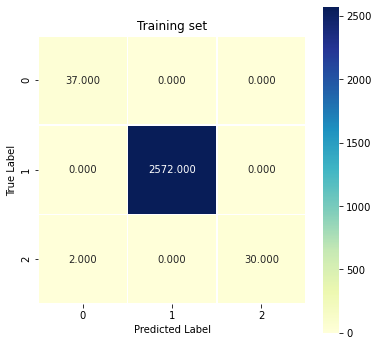

In [135]:

cm_nbtrainn1 = confusion_matrix(y_train, restrain)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrainn1, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');
#after run one class 0 right, class 2 11 wrong 
#after run2 2 wrong in class 2
#run3 2 wrong in class 2

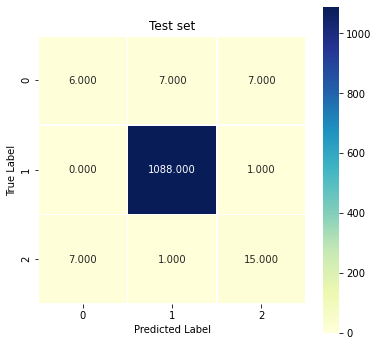

In [136]:
cm_nbtestn1 = confusion_matrix(y_test, restest)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtestn1, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');
#after run 2 unclass 12 wrong, 1 late, 8 in early
#after run3 unclass 14 wrong, ", "

In [137]:
print(f"F1 score (train, class 0) {round(fmeas(cm_nbtrainn1,0),3)}")
print(f"F1 score (train, class 2) {round(fmeas(cm_nbtrainn1,2),3)}")
print(f"F1 score (test, class 0) {round(fmeas(cm_nbtestn1,0),3)}")
print(f"F1 score (test, class 2) {round(fmeas(cm_nbtestn1,2),3)}")

F1 score (train, class 0) 0.974
F1 score (train, class 2) 0.968
F1 score (test, class 0) 0.364
F1 score (test, class 2) 0.652


Text(0, 0.5, 'F1-score')

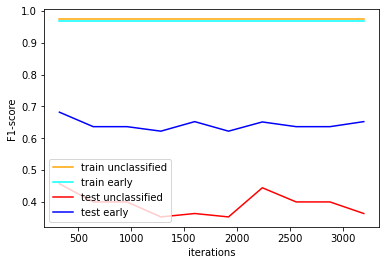

In [138]:
plt.plot(resn1[0],resn1[1],'-',color='orange',ms=10,label='train unclassified') 
plt.plot(resn1[0],resn1[2],'-',color='cyan',ms=10,label='train early') 
plt.plot(resn1[0],resn1[3],'-',color='red',ms=10,label='test unclassified') 
plt.plot(resn1[0],resn1[4],'-',color='blue',ms=10,label='test early') 
plt.legend(loc="best")
plt.xlabel("iterations")
plt.ylabel("F1-score")
#last trial had only class 0 correct in training
#second no rare good 

In [143]:
modeln2 = Sequential(
    [              
        tf.keras.Input(shape=(1900,)),    
        Dense(8, activation="relu", name="layer1"), #, kernel_regularizer=tf.keras.regularizers.L1(0.01))   
        Dense(5, activation="relu", name="layer2"),
        Dense(3, activation = 'linear', name="layer3"),
    ], name = "modeln2"
) 
modeln2.summary()

Model: "modeln2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 8)                 15208     
                                                                 
 layer2 (Dense)              (None, 5)                 45        
                                                                 
 layer3 (Dense)              (None, 3)                 18        
                                                                 
Total params: 15,271
Trainable params: 15,271
Non-trainable params: 0
_________________________________________________________________


In [144]:
modeln2.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(0.001),
)

In [147]:
resn2=np.zeros((5,10))
for i in range(10):
    print(i)
    modeln2.fit(
        xsel_train,y_train,
        epochs=320,batch_size=1900 #all at once because data set is not really large
    )
    resn2[0,i]=(i+1)*320
    prediction1p = modeln2.predict(trainre)
    sm_prediction1p = tf.nn.softmax(prediction1p).numpy()
    restrain=np.zeros(np.shape(prediction1p)[0])
    for j in range(np.shape(prediction1p)[0]): #most likely prediction
        restrain[j]=np.argmax(prediction1p[j])
    prediction1p_test = modeln2.predict(testre)
    sm_prediction1p_test = tf.nn.softmax(prediction1p_test).numpy()
    restest=np.zeros(np.shape(prediction1p_test)[0])
    for j in range(np.shape(prediction1p_test)[0]):
        restest[j]=np.argmax(prediction1p_test[j]) 
    cm_nbtrainn1 = confusion_matrix(y_train, restrain)
    cm_nbtestn1 = confusion_matrix(y_test, restest)
    resn2[1,i]=fmeas(cm_nbtrainn1,0) 
    resn2[2,i]=fmeas(cm_nbtrainn1,2)
    resn2[3,i]=fmeas(cm_nbtestn1,0)
    resn2[4,i]=fmeas(cm_nbtestn1,2)  

0
Epoch 1/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0070
Epoch 2/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0071
Epoch 3/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0070
Epoch 4/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0071
Epoch 5/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0072
Epoch 6/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0071
Epoch 7/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0073
Epoch 8/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0071
Epoch 9/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0071
Epoch 10/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0072
Epoch 11/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0071
Epoch 12/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0071
Epoch 13/320
2/2 [==============================] - 0s 9ms/

2/2 [==============================] - 0s 6ms/step - loss: 0.0063
Epoch 207/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0063
Epoch 208/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0063
Epoch 209/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0063
Epoch 210/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0063
Epoch 211/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0063
Epoch 212/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0063
Epoch 213/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0063
Epoch 214/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0063
Epoch 215/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0063
Epoch 216/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0063
Epoch 217/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0063
Epoch 218/320
2/2 [==============================] - 0

2/2 [==============================] - 0s 7ms/step - loss: 0.0057
Epoch 91/320
2/2 [==============================] - 0s 10ms/step - loss: 0.0057
Epoch 92/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0057
Epoch 93/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 94/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 95/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0057
Epoch 96/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0058
Epoch 97/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0057
Epoch 98/320
2/2 [==============================] - 0s 15ms/step - loss: 0.0057
Epoch 99/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 100/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 101/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0057
Epoch 102/320
2/2 [==============================] - 0s 7ms/s

2/2 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 295/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 296/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0055
Epoch 297/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 298/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 299/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 300/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 301/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 302/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0054
Epoch 303/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 304/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0054
Epoch 305/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 306/320
2/2 [==============================] - 0

2/2 [==============================] - 0s 9ms/step - loss: 0.0051
Epoch 179/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0051
Epoch 180/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0051
Epoch 181/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 182/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0051
Epoch 183/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 184/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0051
Epoch 185/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 186/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0050
Epoch 187/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0050
Epoch 188/320
2/2 [==============================] - 0s 15ms/step - loss: 0.0050
Epoch 189/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0050
Epoch 190/320
2/2 [==============================] - 

2/2 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 63/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 64/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 65/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 66/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0047
Epoch 67/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 68/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0047
Epoch 69/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 70/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0048
Epoch 71/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0047
Epoch 72/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 73/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 74/320
2/2 [==============================] - 0s 6ms/step -

2/2 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 166/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 167/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0045
Epoch 168/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0046
Epoch 169/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0046
Epoch 170/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 171/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 172/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0046
Epoch 173/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 174/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 175/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 176/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 177/320
2/2 [==============================] - 0

2/2 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 49/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 50/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 51/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 52/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0043
Epoch 53/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0043
Epoch 54/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0043
Epoch 55/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 56/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 57/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0043
Epoch 58/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0043
Epoch 59/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0043
Epoch 60/320
2/2 [==============================] - 0s 7ms/step -

2/2 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 254/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 255/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 256/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 257/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 258/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 259/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 260/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0043
Epoch 261/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 262/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 263/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 264/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 265/320
2/2 [==============================] - 0

2/2 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 138/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 139/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0042
Epoch 140/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0042
Epoch 141/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 142/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 143/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 144/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0041
Epoch 145/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 146/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0041
Epoch 147/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 148/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 149/320
2/2 [==============================] - 0

2/2 [==============================] - 0s 6ms/step - loss: 0.0041
Epoch 21/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0040
Epoch 22/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0041
Epoch 23/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0040
Epoch 24/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 25/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 26/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0040
Epoch 27/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0040
Epoch 28/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0040
Epoch 29/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0040
Epoch 30/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0040
Epoch 31/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0040
Epoch 32/320
2/2 [==============================] - 0s 6ms/step -

2/2 [==============================] - 0s 6ms/step - loss: 0.0040
Epoch 226/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 227/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 228/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 229/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 230/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 231/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 232/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 233/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 234/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 235/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0040
Epoch 236/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 237/320
2/2 [==============================] - 0

2/2 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 110/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 111/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 112/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 113/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 114/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 115/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0038
Epoch 116/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0038
Epoch 117/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 118/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0039
Epoch 119/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 120/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0038
Epoch 121/320
2/2 [==============================] - 0

2/2 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 314/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0038
Epoch 315/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 316/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0038
Epoch 317/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0038
Epoch 318/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 319/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0038
Epoch 320/320
36/36 [==============================] - 0s 2ms/step
8
Epoch 1/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 2/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 3/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 4/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 5/320
2/2 [==============================] - 0s 9ms/step - loss: 0.

2/2 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 198/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0037
Epoch 199/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0037
Epoch 200/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 201/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0037
Epoch 202/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0037
Epoch 203/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0037
Epoch 204/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0037
Epoch 205/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0037
Epoch 206/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0037
Epoch 207/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0037
Epoch 208/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0037
Epoch 209/320
2/2 [==============================] - 0

2/2 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 82/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 83/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 84/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 85/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0036
Epoch 86/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 87/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 88/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 89/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 90/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 91/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0036
Epoch 92/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0036
Epoch 93/320
2/2 [==============================] - 0s 7ms/step -

2/2 [==============================] - 0s 8ms/step - loss: 0.0035
Epoch 286/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 287/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 288/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0035
Epoch 289/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 290/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 291/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 292/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 293/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0035
Epoch 294/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0035
Epoch 295/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 296/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 297/320
2/2 [==============================] - 0

Text(0, 0.5, 'F1-score')

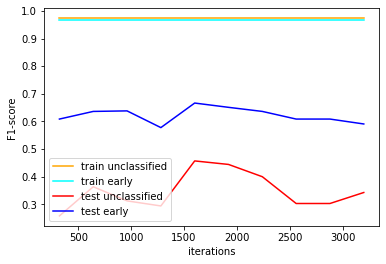

In [148]:
plt.plot(resn2[0],resn2[1],'-',color='orange',ms=10,label='train unclassified') 
plt.plot(resn2[0],resn2[2],'-',color='cyan',ms=10,label='train early') 
plt.plot(resn2[0],resn2[3],'-',color='red',ms=10,label='test unclassified') 
plt.plot(resn2[0],resn2[4],'-',color='blue',ms=10,label='test early') 
plt.legend(loc="best")
plt.xlabel("iterations")
plt.ylabel("F1-score")
#Trial 1 first gets early *but train worse than test) and then fits unclassified
#Trial 2 gets it right saved as
#np.savetxt("class_twolayer_nn_v1.txt",resn2)
#next trial does not work
#next overfit unclassfied early , early not yet so good
#further running, random changes

As visisble the perfermance reduces after 1000 to 2000 iterations. Thus there there is overfitting and we need to regularize to avoid it.

In [149]:
#1D convolution
xsel_trainc = xsel_train.reshape(xsel_train.shape[0], round(xsel_train.shape[1]/1), 1)
xsel_testc = xsel_test.reshape(xsel_test.shape[0], round(xsel_test.shape[1]/1), 1)
print(np.shape(xsel_trainc))
#still not which 1d network does the right thing here, difficult in any case maybeter add more feature engeniering for logistic

(2641, 1900, 1)


In [151]:
model6 = Sequential(
    [              
        Conv1D(100,19, activation="relu",strides=1, padding="same", name="layer1",input_shape=(1900,1)),   #1 piece of length 1900
        MaxPooling1D(pool_size=8),
        Flatten(),
        Dense(10, activation="relu", name="layer3"),        
        Dense(3, activation = "linear")
    ], name = "model6"
) 
model6.summary()
#need to understand conv1d more (probably check conv2v also )

Model: "model6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Conv1D)             (None, 1900, 100)         2000      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 237, 100)         0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 23700)             0         
                                                                 
 layer3 (Dense)              (None, 10)                237010    
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 239,043
Trainable params: 239,043
Non-trainable params: 0
______________________________________________________

In [51]:
model6.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(0.001),
)

In [52]:
resn6=np.zeros((5,10))
for i in range(10):
    print(i)
    model6.fit(
        xsel_trainc,y_train,
        epochs=100,batch_size=1900) #all at once because data set is not really large
    
    resn6[0,i]=(i+1)*100
    prediction1p = model6.predict(xsel_trainc)
    sm_prediction1p = tf.nn.softmax(prediction1p).numpy()
    restrain=np.zeros(np.shape(prediction1p)[0])
    for j in range(np.shape(prediction1p)[0]): #most likely prediction
        restrain[j]=np.argmax(prediction1p[j])
    prediction1p_test = model6.predict(xsel_testc)
    sm_prediction1p_test = tf.nn.softmax(prediction1p_test).numpy()
    restest=np.zeros(np.shape(prediction1p_test)[0])
    for j in range(np.shape(prediction1p_test)[0]):
        restest[j]=np.argmax(prediction1p_test[j]) 
    cm_nbtrainn1 = confusion_matrix(y_train, restrain)
    cm_nbtestn1 = confusion_matrix(y_test, restest)
    resn6[1,i]=fmeas(cm_nbtrainn1,0) 
    resn6[2,i]=fmeas(cm_nbtrainn1,2)
    resn6[3,i]=fmeas(cm_nbtestn1,0)
    resn6[4,i]=fmeas(cm_nbtestn1,2)  

0
Epoch 1/100
2/2 [==============================] - 1s 66ms/step - loss: 1.7428
Epoch 2/100
2/2 [==============================] - 0s 67ms/step - loss: 1.2123
Epoch 3/100
2/2 [==============================] - 0s 72ms/step - loss: 1.0641
Epoch 4/100
2/2 [==============================] - 0s 79ms/step - loss: 1.0365
Epoch 5/100
2/2 [==============================] - 0s 81ms/step - loss: 1.0195
Epoch 6/100
2/2 [==============================] - 0s 70ms/step - loss: 1.0148
Epoch 7/100
2/2 [==============================] - 0s 75ms/step - loss: 1.0090
Epoch 8/100
2/2 [==============================] - 0s 68ms/step - loss: 0.9981
Epoch 9/100
2/2 [==============================] - 0s 69ms/step - loss: 0.9861
Epoch 10/100
2/2 [==============================] - 0s 79ms/step - loss: 0.9753
Epoch 11/100
2/2 [==============================] - 0s 69ms/step - loss: 0.9658
Epoch 12/100
2/2 [==============================] - 0s 67ms/step - loss: 0.9566
Epoch 13/100
2/2 [=============================

2/2 [==============================] - 0s 90ms/step - loss: 0.1223
Epoch 3/100
2/2 [==============================] - 0s 89ms/step - loss: 0.1204
Epoch 4/100
2/2 [==============================] - 0s 79ms/step - loss: 0.1198
Epoch 5/100
2/2 [==============================] - 0s 71ms/step - loss: 0.1166
Epoch 6/100
2/2 [==============================] - 0s 70ms/step - loss: 0.1157
Epoch 7/100
2/2 [==============================] - 0s 66ms/step - loss: 0.1141
Epoch 8/100
2/2 [==============================] - 0s 70ms/step - loss: 0.1131
Epoch 9/100
2/2 [==============================] - 0s 80ms/step - loss: 0.1117
Epoch 10/100
2/2 [==============================] - 0s 67ms/step - loss: 0.1105
Epoch 11/100
2/2 [==============================] - 0s 78ms/step - loss: 0.1101
Epoch 12/100
2/2 [==============================] - 0s 90ms/step - loss: 0.1090
Epoch 13/100
2/2 [==============================] - 0s 72ms/step - loss: 0.1074
Epoch 14/100
2/2 [==============================] - 0s 72ms/

2/2 [==============================] - 0s 92ms/step - loss: 0.0387
Epoch 5/100
2/2 [==============================] - 0s 99ms/step - loss: 0.0387
Epoch 6/100
2/2 [==============================] - 0s 109ms/step - loss: 0.0383
Epoch 7/100
2/2 [==============================] - 0s 99ms/step - loss: 0.0390
Epoch 8/100
2/2 [==============================] - 0s 103ms/step - loss: 0.0390
Epoch 9/100
2/2 [==============================] - 0s 107ms/step - loss: 0.0389
Epoch 10/100
2/2 [==============================] - 0s 94ms/step - loss: 0.0386
Epoch 11/100
2/2 [==============================] - 0s 92ms/step - loss: 0.0394
Epoch 12/100
2/2 [==============================] - 0s 101ms/step - loss: 0.0382
Epoch 13/100
2/2 [==============================] - 0s 109ms/step - loss: 0.0382
Epoch 14/100
2/2 [==============================] - 0s 99ms/step - loss: 0.0382
Epoch 15/100
2/2 [==============================] - 0s 94ms/step - loss: 0.0381
Epoch 16/100
2/2 [==============================] - 0

2/2 [==============================] - 0s 110ms/step - loss: 0.0290
Epoch 5/100
2/2 [==============================] - 0s 136ms/step - loss: 0.0290
Epoch 6/100
2/2 [==============================] - 0s 113ms/step - loss: 0.0287
Epoch 7/100
2/2 [==============================] - 0s 110ms/step - loss: 0.0286
Epoch 8/100
2/2 [==============================] - 0s 124ms/step - loss: 0.0285
Epoch 9/100
2/2 [==============================] - 0s 134ms/step - loss: 0.0284
Epoch 10/100
2/2 [==============================] - 1s 163ms/step - loss: 0.0286
Epoch 11/100
2/2 [==============================] - 1s 167ms/step - loss: 0.0285
Epoch 12/100
2/2 [==============================] - 1s 166ms/step - loss: 0.0290
Epoch 13/100
2/2 [==============================] - 1s 170ms/step - loss: 0.0293
Epoch 14/100
2/2 [==============================] - 0s 120ms/step - loss: 0.0289
Epoch 15/100
2/2 [==============================] - 0s 122ms/step - loss: 0.0282
Epoch 16/100
2/2 [============================

2/2 [==============================] - 0s 105ms/step - loss: 0.0229
Epoch 5/100
2/2 [==============================] - 0s 102ms/step - loss: 0.0231
Epoch 6/100
2/2 [==============================] - 0s 97ms/step - loss: 0.0227
Epoch 7/100
2/2 [==============================] - 0s 100ms/step - loss: 0.0225
Epoch 8/100
2/2 [==============================] - 0s 94ms/step - loss: 0.0226
Epoch 9/100
2/2 [==============================] - 0s 98ms/step - loss: 0.0227
Epoch 10/100
2/2 [==============================] - 0s 103ms/step - loss: 0.0226
Epoch 11/100
2/2 [==============================] - 0s 101ms/step - loss: 0.0224
Epoch 12/100
2/2 [==============================] - 0s 92ms/step - loss: 0.0223
Epoch 13/100
2/2 [==============================] - 0s 166ms/step - loss: 0.0224
Epoch 14/100
2/2 [==============================] - 0s 109ms/step - loss: 0.0223
Epoch 15/100
2/2 [==============================] - 0s 115ms/step - loss: 0.0223
Epoch 16/100
2/2 [==============================] 

2/2 [==============================] - 0s 100ms/step - loss: 0.0183
Epoch 5/100
2/2 [==============================] - 0s 97ms/step - loss: 0.0181
Epoch 6/100
2/2 [==============================] - 0s 104ms/step - loss: 0.0181
Epoch 7/100
2/2 [==============================] - 0s 116ms/step - loss: 0.0180
Epoch 8/100
2/2 [==============================] - 0s 100ms/step - loss: 0.0180
Epoch 9/100
2/2 [==============================] - 0s 100ms/step - loss: 0.0181
Epoch 10/100
2/2 [==============================] - 0s 95ms/step - loss: 0.0182
Epoch 11/100
2/2 [==============================] - 0s 94ms/step - loss: 0.0180
Epoch 12/100
2/2 [==============================] - 0s 111ms/step - loss: 0.0179
Epoch 13/100
2/2 [==============================] - 0s 92ms/step - loss: 0.0179
Epoch 14/100
2/2 [==============================] - 0s 94ms/step - loss: 0.0180
Epoch 15/100
2/2 [==============================] - 0s 102ms/step - loss: 0.0180
Epoch 16/100
2/2 [==============================] -

Text(0, 0.5, 'F1-score')

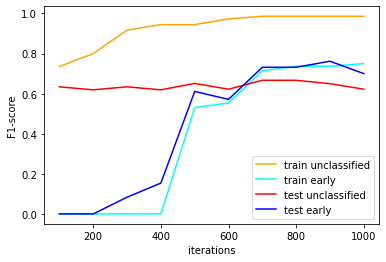

In [53]:
plt.plot(resn6[0],resn6[1],'-',color='orange',ms=10,label='train unclassified') 
plt.plot(resn6[0],resn6[2],'-',color='cyan',ms=10,label='train early') 
plt.plot(resn6[0],resn6[3],'-',color='red',ms=10,label='test unclassified') 
plt.plot(resn6[0],resn6[4],'-',color='blue',ms=10,label='test early') 
plt.legend(loc="best")
plt.xlabel("iterations")
plt.ylabel("F1-score")
#not so good, or just converged? no better should be possible on early (or just overfitting)

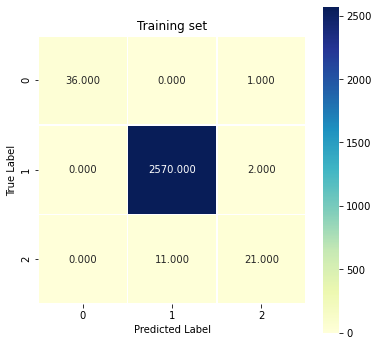

In [54]:

plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrainn1, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

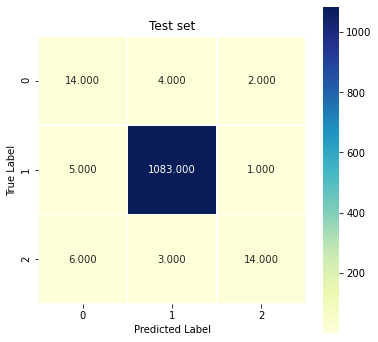

In [55]:

plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtestn1, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

In [ ]:
#two layers maybe, in principle usual for the length
model8 = Sequential(
    [   
        Conv1D(70,16,strides=1, padding="same", activation="relu", name="layer1",input_shape=(141,20),kernel_regularizer=tf.keras.regularizers.L1(0.001)),         
        MaxPooling1D(pool_size=8),
        Conv1D(32,16,strides=1, padding="same", activation="relu", name="layer2",kernel_regularizer=tf.keras.regularizers.L1(0.001)),  
        MaxPooling1D(pool_size=8),        
        Flatten(),        
        Dense(5, activation="relu", name="layer3",kernel_regularizer=tf.keras.regularizers.L1(0.001)),
        Dense(3, activation = "linear")
    ], name = "model8"
) 
